<h1>Coin tossing simulation</h1>
<h2>A really simple and easy way to understand how continuous observation of frequentist A/B tests can reduce their reliability</h2>

### Motivation
Working with A/B tests for product optimization at [GetNinjas](https://www.getninjas.com.br/), an issue that was frequently discussed was the right way of running such tests. As it probably happens in other companies, the statitician's mindset is not so pleasing to developers and leaders regarding the good practices of not peeking at the data before reaching the number of samples defined beforehand.

Being a fast growing business, there is always some rush in taking actions quickly and optimizing every aspect of the product. However, using the frequentist methodology, data snooping and unintentional p-hacking can lead to a significant rise in false positives.

To try and show this in a way that is easy to digest, this notebook simulates several tosses of two identical coins to demonstrate how continuous observation can be misleading.

### A little on p-values and null hypothesis
When using a frequentist approach to A/B testing, Student's T-Test is often used to verify if there is a notable diference between each variation. The __null hypothesis__ is simply whatever you are trying to disprove. The __p-value__, or probability value, is the probability that the result you got out of the test was just by chance. It can be defined as the probability that an A/A test would create results at least as extreme as the ones you got

For this simulation, we have:
* __null_hypothesis__: The coins are identical and the chances of heads or tails is the same for both

### The simulation
Let's start by importing what will be needed

In [1]:
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

Then, define some global variables to make the code readable

In [2]:
HEADS = 1
TAILS = 0
NUMBER_OF_SAMPLES = 10000
NUMBER_OF_TESTS = 1000
P_VALUE_LIMIT = 0.05

The number of samples is the size of the test and the number of tests is the number of times we will run the simulation

__coin_toss()__: Just a method to choose randomly between heads and tails

In [3]:
def coin_toss():
    """Returns HEADS or TAILS randomly"""
    return random.choice([HEADS,TAILS])

##### Main simulation method

__early_stops:__ counter for the number of tests the p-value fell below the determined limit along the way

__end_of_test:__ counter for the number of tests where the final p-value was below the limit

In [4]:
def simulate_tosses(n_tests,test_size):
    """
    Runs a given number of coin tossing tests of chosen size and shows the results
    """
    early_stops = 0
    end_of_test = 0

    for test_number in range(n_tests):
        coin_1 = []
        coin_2 = []
        should_stop = False
        for sample in range(test_size):
            coin_1.append(coin_toss())
            coin_2.append(coin_toss())
            # This condition just avoids the big initial oscilations of p-value to affect the result
            if sample > test_size/10:
                stat_power,p_value = stats.ttest_ind(coin_1,coin_2)
                if p_value < P_VALUE_LIMIT:
                    should_stop = True
        if should_stop:
            early_stops += 1
        if p_value < P_VALUE_LIMIT:
            end_of_test += 1
            
    print('After {0} runs of {1} tosses, the results are:'.format(n_tests,test_size))
    print('{0} tests ({1}%) got a false positive after the whole run'.format(end_of_test,round(100*end_of_test/n_tests)))
    print('{0} tests ({1}%) would have been stopped too early and gotten a false positive'.format(early_stops,round(100*early_stops/n_tests)))

#### Let's run

In [5]:
simulate_tosses(NUMBER_OF_TESTS,NUMBER_OF_SAMPLES)

After 1000 runs of 10000 tosses, the results are:
47 tests (5%) got a false positive after the whole run
311 tests (31%) would have been stopped too early and gotten a false positive


##### Results
As it is shown by the results above, the runs were we just looked at the results at the end of the test got a number of false positives pretty close to what was expected (5% for a p-value of 0.05)

Nonetheless, the continuous monitoring of the test led to a much greater number of false positives. To further understand that, we can run a smaller number of tests and check what happens to the p-value throughout the test run

In [6]:
def plot_p_values(test_size,n=3,m=3):
    """
    Runs n*m coin tossing simulations and displays the p-value evolution throughout the tests in a nxm grid 
    """
    tests = n*m
    p_values = []
    
    for test_number in range(tests):
        running_p_value = []
        coin_1 = []
        coin_2 = []
        for sample in range(test_size):
            coin_1.append(coin_toss())
            coin_2.append(coin_toss())
            stat_power,p_value = stats.ttest_ind(coin_1,coin_2)
            running_p_value.append(np.nan_to_num(p_value,1))
        p_values.append(running_p_value)
        
    fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(18, 12))
    x_axis = np.linspace(1,NUMBER_OF_SAMPLES,NUMBER_OF_SAMPLES)
    p_ref = np.ones(NUMBER_OF_SAMPLES)*P_VALUE_LIMIT
    
    for i,row in enumerate(axes):
        for j,ax in enumerate(row):
            ax.plot(x_axis,p_values[n*i+j])
            ax.plot(x_axis,p_ref)

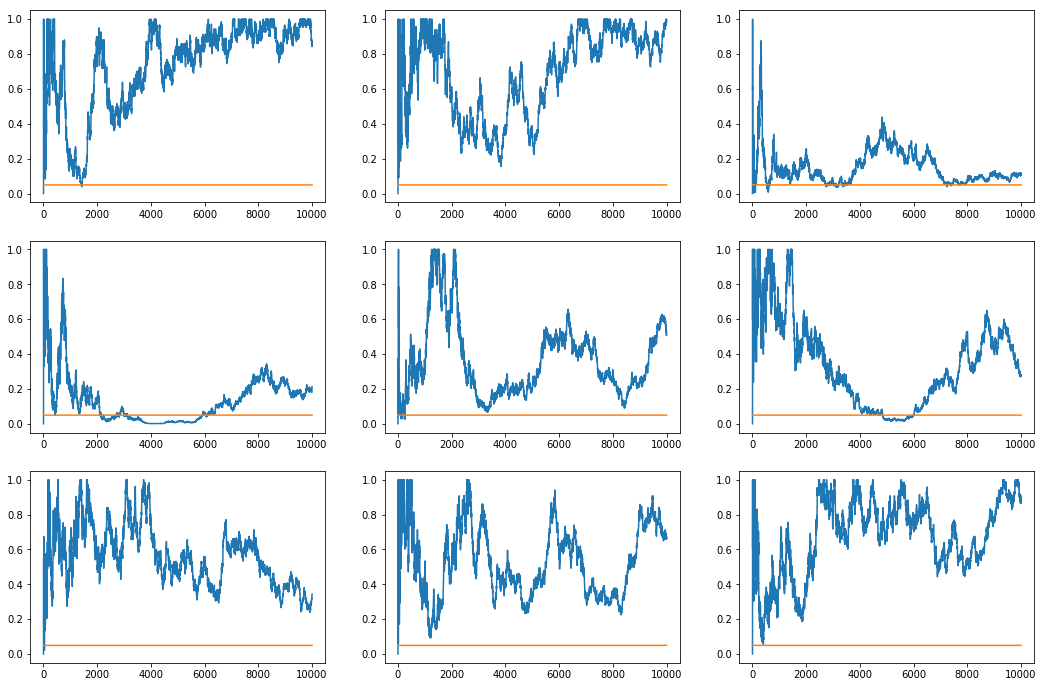

In [7]:
plot_p_values(NUMBER_OF_SAMPLES)

As it can be seen from the graphs above, although the p-value normally does not cross the value stablished, if you stop your test before you get all the predetermined samples, you are going to get false positives more frequently. Even if unintentional, this continuous observation consists of p-hacking and leads to false results.
<h2>Don't peek at your data</h2>

If you want to use a frequentist approach, it can be a good method, but only if you stick to the good practices of not looking at your data.

Another solution is to use some different methodology, like Bayesian Inference, or maybe not use A/B's at all. There are other options for product optimization

Just make sure that, whatever you use, you use it right